Configuration and Data Loading

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, silhouette_score, homogeneity_score

# ==============================================================================
# 1. CONFIGURATION AND DATA LOADING
# ==============================================================================

# Location where features and labels were saved
data_save_location = Path(r'D:\YV\DSGP-IIT\disease and pest detection')

# Load the saved feature arrays
X = np.load(data_save_location / 'extracted_features_X.npy')
y = np.load(data_save_location / 'extracted_labels_y.npy')
class_map = np.load(data_save_location / 'class_mapping.npy', allow_pickle=True).item()

# Reverse the map for readable labels
index_to_class = {v: k for k, v in class_map.items()}
class_names = [index_to_class[i] for i in sorted(index_to_class.keys())]
NUM_CLASSES = len(class_names)

print("Features Loaded.")
print(f"Total samples: {X.shape[0]}, Total features: {X.shape[1]}")
print(f"Number of classes: {NUM_CLASSES}")

# Split data into training and testing sets (70% train, 30% test)
# Stratify=y ensures the training and testing sets maintain the class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale the data (Crucial for distance-based models like SVM, k-NN, and Unsupervised)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled_all = scaler.transform(X) # Needed for unsupervised learning on the full dataset

print(f"Data Split: Training={X_train.shape[0]}, Testing={X_test.shape[0]}")

Features Loaded.
Total samples: 39418, Total features: 512
Number of classes: 16
Data Split: Training=27592, Testing=11826


Supervised Learning model Evaluation

In [2]:
# ==============================================================================
# 2. SUPERVISED MODEL TRAINING AND EVALUATION
# ==============================================================================

supervised_models = {
    "SVM (Support Vector Machine)": SVC(kernel='linear', C=1.0, random_state=42),
    "k-NN (k-Nearest Neighbors)": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
}

supervised_results = {}

for name, model in supervised_models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Store metrics
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    supervised_results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "report": report,
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

    # Print the detailed classification report
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))


--- Training SVM (Support Vector Machine) ---
                    precision    recall  f1-score   support

       Heliopeltis       0.53      0.58      0.55       627
          Red Rust       0.88      0.89      0.88       992
        Red Spider       0.47      0.44      0.46       606
Sunlight Scorching       0.78      0.74      0.76       514
            Thrips       0.92      0.92      0.92       986
   Tea leaf blight       1.00      1.00      1.00       828
 Tea red leaf spot       0.99      1.00      1.00       728
      Tea red scab       1.00      1.00      1.00       778
        algal leaf       0.84      0.88      0.86       818
       Anthracnose       0.98      0.97      0.97      1031
     bird eye spot       0.97      0.98      0.98      1018
      brown blight       0.77      0.78      0.78       585
        gray light       0.98      0.98      0.98       728
        white spot       0.98      0.98      0.98       718
       Gray Blight       0.77      0.72      0.74   

Unsupervised learning and evaluation

In [3]:
# ==============================================================================
# 3. UNSUPERVISED LEARNING (K-Means Clustering)
# ==============================================================================
print("\n--- Unsupervised Learning: K-Means Clustering ---")

# We use K-Means with the actual number of classes (NUM_CLASSES)
kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=42, n_init=10)
# We train K-Means on the ENTIRE scaled dataset (X_scaled_all)
kmeans.fit(X_scaled_all)
y_clusters = kmeans.predict(X_scaled_all)

# Evaluation for Unsupervised Models (no 'True' labels used for training)
# 1. Homogeneity: Measures if each cluster contains only data points belonging to a single class.
homogeneity = homogeneity_score(y, y_clusters)
# 2. Silhouette Score: Measures how similar an object is to its own cluster compared to others.
silhouette = silhouette_score(X_scaled_all, y_clusters)

print(f"K-Means Clustering Performance (Clusters={NUM_CLASSES}):")
print(f"  Homogeneity Score (Clustering Purity): {homogeneity:.4f}")
print(f"  Silhouette Score (Cluster Separation): {silhouette:.4f}")

# IMPORTANT: Unsupervised models require special visualization (e.g., PCA/t-SNE reduction)
# to show cluster separation, which is beyond the scope of this core script.


--- Unsupervised Learning: K-Means Clustering ---
K-Means Clustering Performance (Clusters=16):
  Homogeneity Score (Clustering Purity): 0.5805
  Silhouette Score (Cluster Separation): 0.0838


Comparison and Visualization


--- Generating Learning Curves ---
Plotting: SVM (Support Vector Machine)


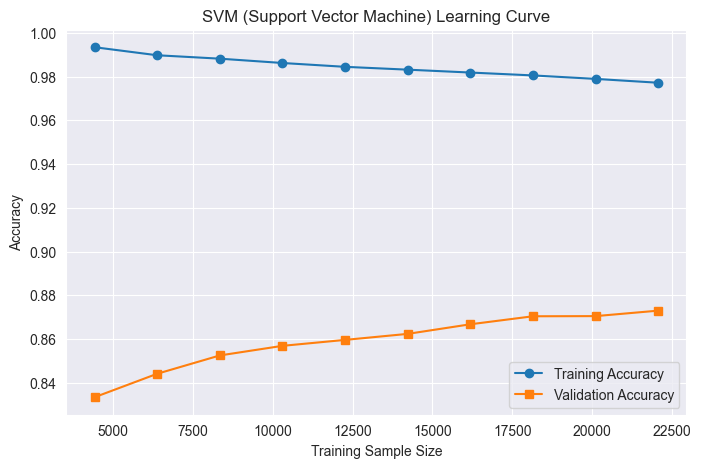

Plotting: k-NN (k-Nearest Neighbors)


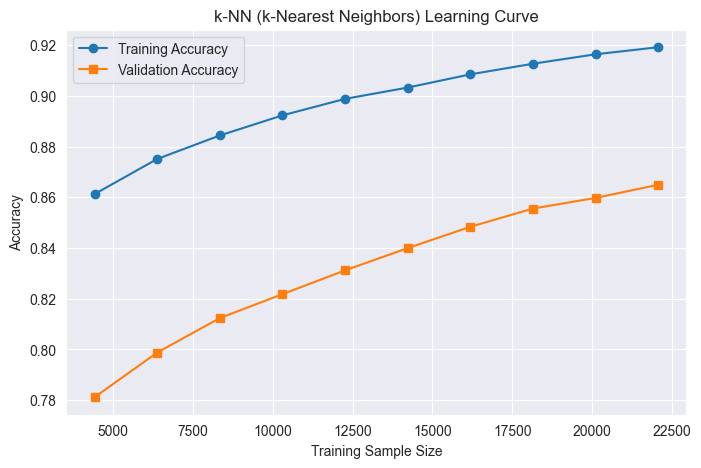

Plotting: Decision Tree


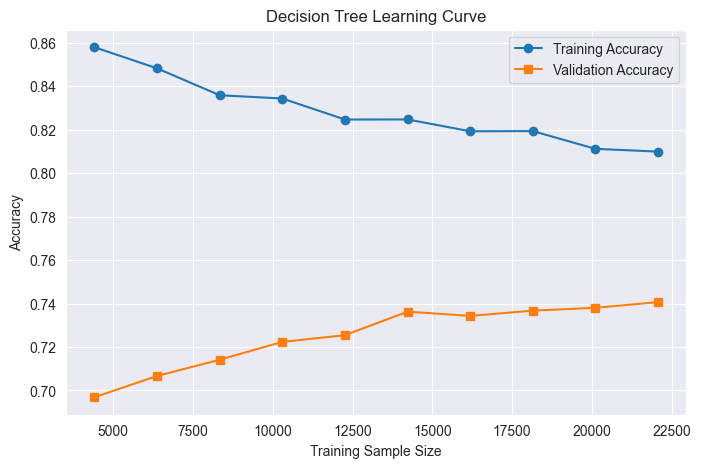

Plotting: Random Forest


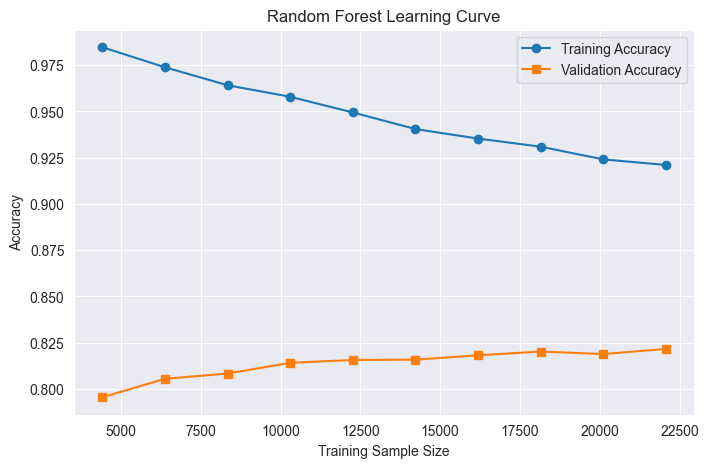



--- 🏆 Final Supervised Model Performance Comparison 🏆 ---


,Model,Accuracy,F1-Score (Weighted Avg),Precision (Weighted Avg),Recall (Weighted Avg)
0,SVM (Support Vector Machine),0.8764,0.8762,0.8764,0.8764
1,k-NN (k-Nearest Neighbors),0.8751,0.8709,0.8740,0.8751
2,Decision Tree,0.7440,0.7349,0.7416,0.7440
3,Random Forest,0.8276,0.8165,0.8250,0.8276


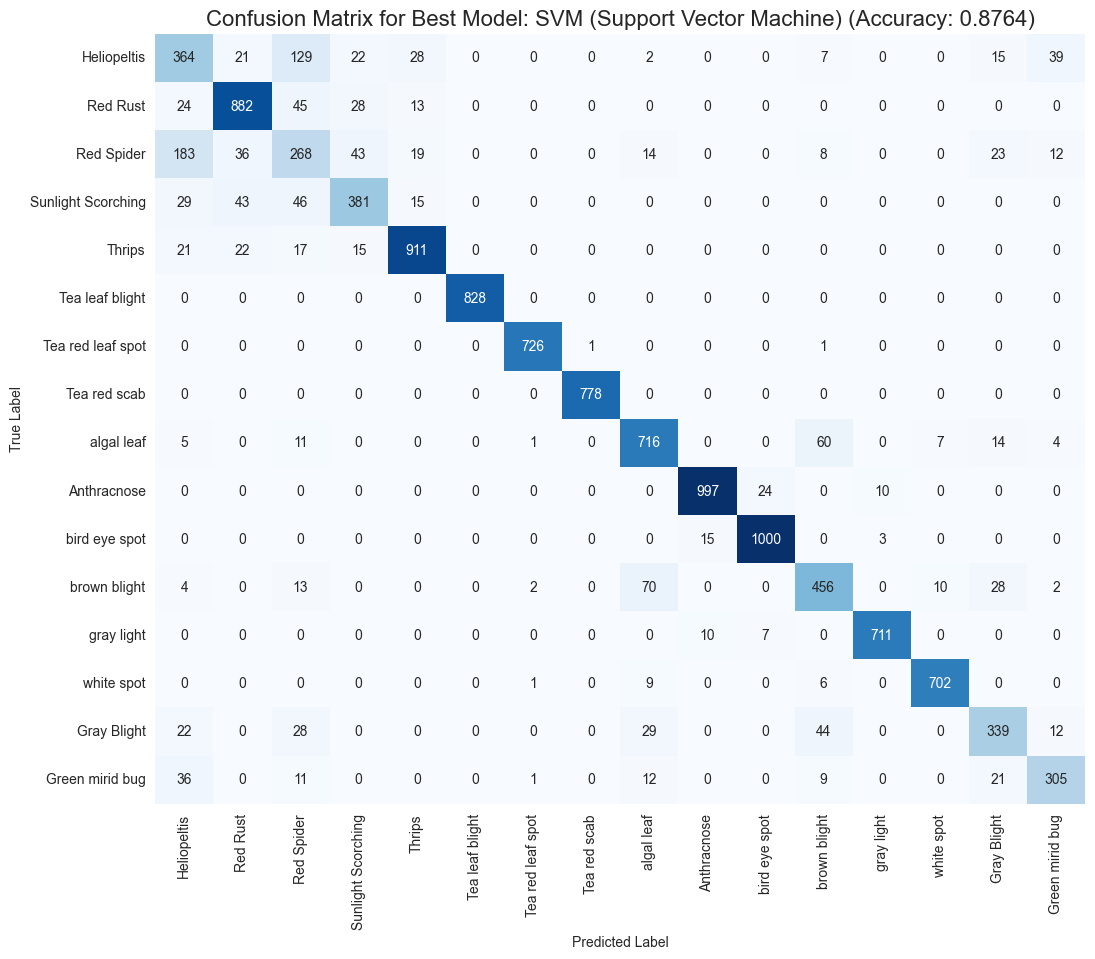


Conclusion: Best model is **SVM (Support Vector Machine)**, accuracy = 0.8764
K-Means confirms class separability (Homogeneity=0.5805)


In [4]:
# ==============================================================================
# 4. TRAINING / VALIDATION LEARNING CURVES
# ==============================================================================

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X, y,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        train_sizes=np.linspace(0.2, 1.0, 10),
        shuffle=True,
        random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, marker='o', label="Training Accuracy")
    plt.plot(train_sizes, val_mean, marker='s', label="Validation Accuracy")
    plt.title(title)
    plt.xlabel("Training Sample Size")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

print("\n--- Generating Learning Curves ---")
for name, model in supervised_models.items():
    print(f"Plotting: {name}")
    plot_learning_curve(model, X_train_scaled, y_train, f"{name} Learning Curve")


# ==============================================================================
# 5. FINAL MODEL COMPARISON, CONFUSION MATRIX & CONCLUSION
# ==============================================================================

# %% Visual comparison
import seaborn as sns
from IPython.display import display

comparison_data = []
if 'supervised_results' not in locals() or not supervised_results:
    print("ERROR: supervised_results dictionary missing. Run training first.")
else:
    for name, res in supervised_results.items():
        if 'report' in res and 'weighted avg' in res['report']:
            comparison_data.append({
                'Model': name,
                'Accuracy': res['accuracy'],
                'F1-Score (Weighted Avg)': res['report']['weighted avg']['f1-score'],
                'Precision (Weighted Avg)': res['report']['weighted avg']['precision'],
                'Recall (Weighted Avg)': res['report']['weighted avg']['recall']
            })

    comparison_df = pd.DataFrame(comparison_data)

    best_model_name = comparison_df.loc[comparison_df['Accuracy'].idxmax()]['Model']
    best_model_accuracy = comparison_df.loc[comparison_df['Accuracy'].idxmax()]['Accuracy']

    print("\n\n--- 🏆 Final Supervised Model Performance Comparison 🏆 ---")
    display(comparison_df.style.format({'Accuracy': '{:.4f}',
                                       'F1-Score (Weighted Avg)': '{:.4f}',
                                       'Precision (Weighted Avg)': '{:.4f}',
                                       'Recall (Weighted Avg)': '{:.4f}'}))

    best_model_cm = supervised_results[best_model_name]["confusion_matrix"]

    plt.figure(figsize=(12, 10))
    sns.heatmap(best_model_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)

    plt.title(f'Confusion Matrix for Best Model: {best_model_name} (Accuracy: {best_model_accuracy:.4f})', fontsize=16)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print("\n" + "="*80)
    print(f"Conclusion: Best model is **{best_model_name}**, accuracy = {best_model_accuracy:.4f}")
    if 'homogeneity' in locals():
        print(f"K-Means confirms class separability (Homogeneity={homogeneity:.4f})")
    else:
        print("K-Means homogeneity metric missing.")
    print("="*80)